# Scientific Paper Recommender System

Working on a chunk size of 50000 on the arXiv Dataset. Follows the given steps of executions

1. Extract Embeddings using SciBert
2. K-Means clustering
3. Testing on the given dataset

## Dataset Loading

In [1]:
!pip install kaggle

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d Cornell-University/arxiv -p /content/
!unzip /content/arxiv.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.40G/1.41G [00:13<00:00, 167MB/s]
100% 1.41G/1.41G [00:13<00:00, 115MB/s]
Archive:  /content/arxiv.zip
  inflating: arxiv-metadata-oai-snapshot.json  


In [2]:
import pandas as pd

file_path = "arxiv-metadata-oai-snapshot.json"

chunk_size = 50000
df_chunk = pd.read_json(file_path, lines=True, chunksize=chunk_size)
df = next(df_chunk)
df1 = df[["abstract"]]

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              50000 non-null  float64
 1   submitter       50000 non-null  object 
 2   authors         50000 non-null  object 
 3   title           50000 non-null  object 
 4   comments        43939 non-null  object 
 5   journal-ref     25683 non-null  object 
 6   doi             30452 non-null  object 
 7   report-no       4814 non-null   object 
 8   categories      50000 non-null  object 
 9   license         6951 non-null   object 
 10  abstract        50000 non-null  object 
 11  versions        50000 non-null  object 
 12  update_date     50000 non-null  object 
 13  authors_parsed  50000 non-null  object 
dtypes: float64(1), object(13)
memory usage: 5.3+ MB
None
         id           submitter  \
0  704.0001      Pavel Nadolsky   
1  704.0002        Louis Theran   
2  704.0

## Extracting embeddings using SciBERT

In [3]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
import numpy as np
import re

MODEL_NAME = "allenai/scibert_scivocab_uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = TFAutoModel.from_pretrained(MODEL_NAME, from_pt=True)

def get_embedding_batch(texts):
    inputs = tokenizer(texts, return_tensors="tf", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs).last_hidden_state
    embeddings = tf.reduce_mean(outputs, axis=1)
    return embeddings.numpy().astype(np.float64)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

In [4]:
batch_size = 128

#Preprocessing to remove numbers so that the metric calculations doesnt take numbers from the abstract for common words
def remove_numbers(text):
    return re.sub(r'\b\d+\b', '', text)

df['abstract_cleaned'] = df['abstract'].fillna("").apply(remove_numbers)

dataset = tf.data.Dataset.from_tensor_slices(df["abstract_cleaned"].tolist())
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

embeddings = []
for batch_texts in dataset:
    batch_texts = [str(text) for text in batch_texts.numpy().tolist()]
    batch_embeddings = get_embedding_batch(batch_texts)
    embeddings.append(batch_embeddings)
embeddings = np.vstack(embeddings)

## K-Means Clustering with K=50

In [5]:
from sklearn.cluster import KMeans
import joblib

num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(embeddings)

joblib.dump(kmeans, "kmeans_model.pkl")
df.to_csv("clustered_arxiv_papers.csv", index=False)

print("Training Completed. Model saved.")

Training Completed. Model saved.


## Recommending Papers with title and link

In [6]:
def recommend_papers(input_abstract, top_n=5):
    embedding = get_embedding_batch([input_abstract])
    kmeans = joblib.load("kmeans_model.pkl")
    cluster = kmeans.predict(embedding)[0]
    clustered_df = pd.read_csv("clustered_arxiv_papers.csv")

    relevant_papers = clustered_df[clustered_df['cluster'] == cluster]
    num_relevant_papers = len(relevant_papers)
    n_samples = min(top_n, num_relevant_papers)

    recommendations = relevant_papers[['id', 'title']].sample(n=n_samples, random_state=42)

    return [(row['title'], f"https://arxiv.org/abs/0{row['id']}") for _, row in recommendations.iterrows()]

In [7]:
abstracts = [
    "Quantum computing algorithms for solving optimization problems in logistics and supply chain management.",
    "Neural network approaches for analyzing medical imaging data in radiology and disease diagnosis.",
    "Blockchain-based decentralized identity management systems for enhancing security and privacy.",
    "Advancements in reinforcement learning techniques for autonomous robotics and navigation.",
    "Ethical implications of artificial intelligence in decision-making and social policies.",
    "High-energy astrophysics and the study of black holes using gravitational wave observations."
]

for abstract in abstracts:
    print(f"\nInput Abstract: {abstract}\n")
    recommended_papers = recommend_papers(abstract)
    for i, (title, link) in enumerate(recommended_papers, 1):
        print(f"Recommended Paper {i}: {title}\n{link}\n")


Input Abstract: Quantum computing algorithms for solving optimization problems in logistics and supply chain management.

Recommended Paper 1: QCD on the Cell Broadband Engine
https://arxiv.org/abs/0710.2442

Recommended Paper 2: Cross Comparison of Synonym Graphs in A Multi Linguistic Context
https://arxiv.org/abs/0709.2476

Recommended Paper 3: Thermal Benchmark and Power Benchmark Software
https://arxiv.org/abs/0709.1834

Recommended Paper 4: Narratives within immersive technologies
https://arxiv.org/abs/0704.2542

Recommended Paper 5: Designer-Driven Topology Optimization for Pipelined Analog to Digital
  Converters
https://arxiv.org/abs/0710.4722


Input Abstract: Neural network approaches for analyzing medical imaging data in radiology and disease diagnosis.

Recommended Paper 1: QCD on the Cell Broadband Engine
https://arxiv.org/abs/0710.2442

Recommended Paper 2: Cross Comparison of Synonym Graphs in A Multi Linguistic Context
https://arxiv.org/abs/0709.2476

Recommended Paper

In [ ]:
from google.colab import files

files.download('/content/clustered_arxiv_papers.csv')
files.download('/content/kmeans_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Metrics

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
cosine_sim_matrix = cosine_similarity(embeddings)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['abstract'].fillna(""))
tfidf_sim_matrix = cosine_similarity(tfidf_matrix)

if 'citations' in df.columns:
    df['citation_count'] = df['citations'].fillna(0).astype(int)
    co_citation_matrix = cosine_similarity(df[['citation_count']])
else:
    print("Warning: 'citations' column not found. Co-citation metric will not be computed.")
    co_citation_matrix = None

In [ ]:
print("\nSimilarity Metrics Computed:")
print("Cosine Similarity Matrix Shape:", cosine_sim_matrix.shape)
print("TF-IDF Similarity Matrix Shape:", tfidf_sim_matrix.shape)
if co_citation_matrix is not None:
    print("Co-Citation Matrix Shape:", co_citation_matrix.shape)

print("Total Papers Processed:", len(df))
print("Number of Clusters:", num_clusters)
print("Cluster Distribution:", df['cluster'].value_counts())


Similarity Metrics Computed:
Cosine Similarity Matrix Shape: (10000, 10000)
TF-IDF Similarity Matrix Shape: (10000, 10000)
Total Papers Processed: 10000
Number of Clusters: 50
Cluster Distribution: cluster
19    328
8     299
41    298
0     274
15    263
26    263
44    254
9     253
32    248
29    247
16    244
14    242
42    240
23    234
39    232
35    226
46    225
37    218
21    217
12    212
38    205
1     204
2     203
28    202
34    202
6     196
47    195
49    189
13    189
24    184
25    182
5     179
36    175
4     174
45    171
22    170
27    169
3     165
48    163
20    160
31    159
33    157
30    150
11    142
17    141
40    137
18    125
7     122
43    100
10     73
Name: count, dtype: int64


In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize

embeddings = normalize(embeddings, norm='l2')
cosine_sim_matrix = cosine_similarity(embeddings)

svd = TruncatedSVD(n_components=300)
reduced_cos = svd.fit_transform(cosine_sim_matrix)
cosine_sim_matrix = cosine_similarity(reduced_cos)

In [ ]:
print("\nFirst 10 Entries of Cosine Similarity Matrix:")
print(cosine_sim_matrix[:10, :10])


First 10 Entries of Cosine Similarity Matrix:
[[1.         0.99867667 0.99941558 0.99713098 0.99685264 0.99946509
  0.99939853 0.99912468 0.99685495 0.99838385]
 [0.99867667 1.         0.99929352 0.99862416 0.99873467 0.99923267
  0.99937021 0.99945228 0.99539632 0.99977108]
 [0.99941558 0.99929352 1.         0.99830063 0.99808657 0.9995687
  0.9994735  0.99967696 0.99632233 0.9991602 ]
 [0.99713098 0.99862416 0.99830063 1.         0.99952383 0.99835927
  0.99849886 0.99870682 0.99044363 0.9993434 ]
 [0.99685264 0.99873467 0.99808657 0.99952383 1.         0.99827169
  0.99820307 0.99834454 0.99071639 0.99930418]
 [0.99946509 0.99923267 0.9995687  0.99835927 0.99827169 1.
  0.9997655  0.99964308 0.9952319  0.99923949]
 [0.99939853 0.99937021 0.9994735  0.99849886 0.99820307 0.9997655
  1.         0.99966876 0.99509393 0.99942501]
 [0.99912468 0.99945228 0.99967696 0.99870682 0.99834454 0.99964308
  0.99966876 1.         0.99513022 0.99949799]
 [0.99685495 0.99539632 0.99632233 0.990443

In [ ]:
tfidf = TfidfVectorizer(stop_words='english', token_pattern=r'(?u)\b[a-zA-Z]{2,}\b')
tfidf_matrix = tfidf.fit_transform(df['abstract_cleaned'])

print("Top TF-IDF words:", tfidf.get_feature_names_out()[:20])

Top TF-IDF words: ['aa' 'aab' 'aac' 'aadl' 'aaomega' 'aarseth' 'aas' 'aassumptions' 'aat'
 'ab' 'abandon' 'abandoned' 'abba' 'abbott' 'abbreviated' 'abbreviation'
 'abc' 'abcd' 'abe' 'abel']



Visualizing Similarity Matrices:


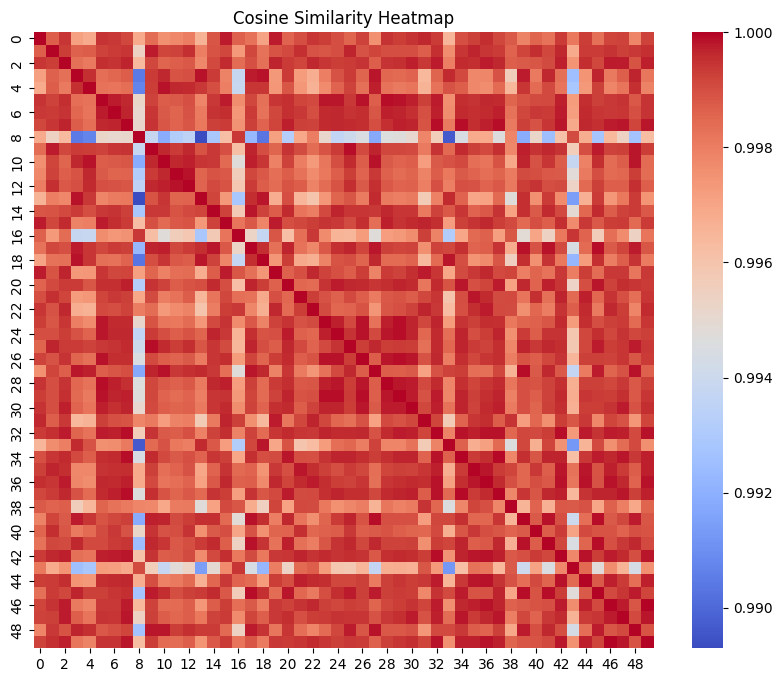

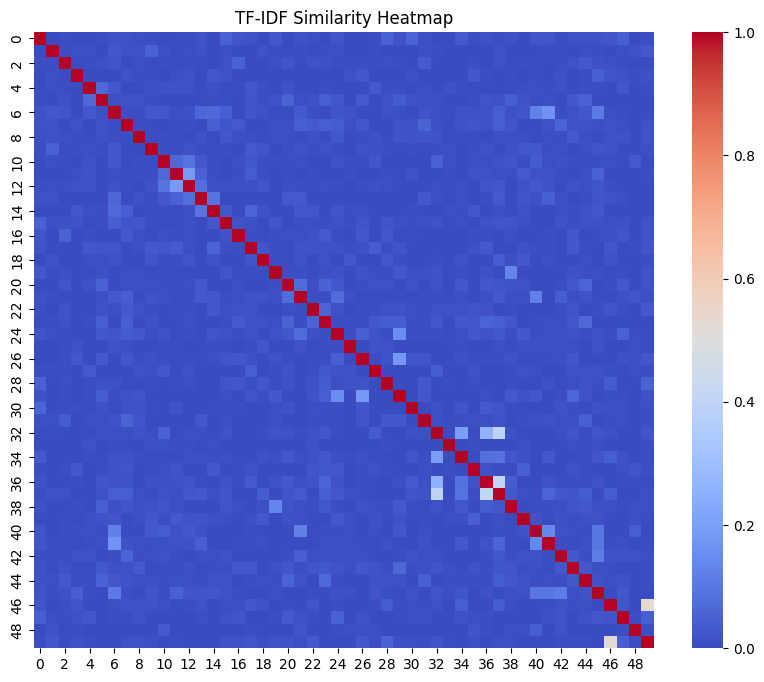

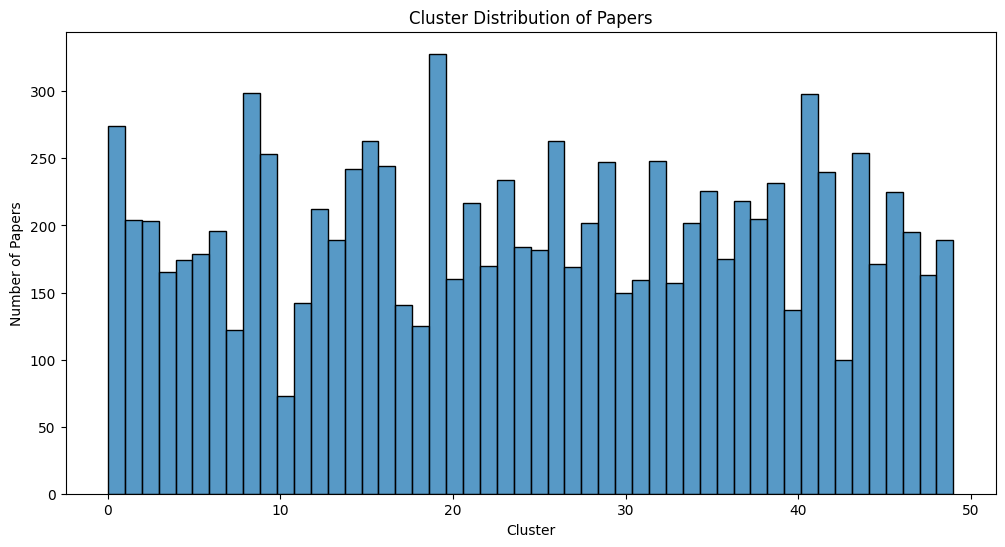

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

def plot_similarity_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix[:50, :50], cmap="coolwarm", annot=False)
    plt.title(title)
    plt.show()

print("\nVisualizing Similarity Matrices:")
plot_similarity_matrix(cosine_sim_matrix, "Cosine Similarity Heatmap")
plot_similarity_matrix(tfidf_sim_matrix, "TF-IDF Similarity Heatmap")

plt.figure(figsize=(12, 6))
sns.histplot(df['cluster'], bins=num_clusters, kde=False)
plt.xlabel("Cluster")
plt.ylabel("Number of Papers")
plt.title("Cluster Distribution of Papers")
plt.show()

<ipython-input-20-49d74a9967ce>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words, y=idf_values, palette="viridis")


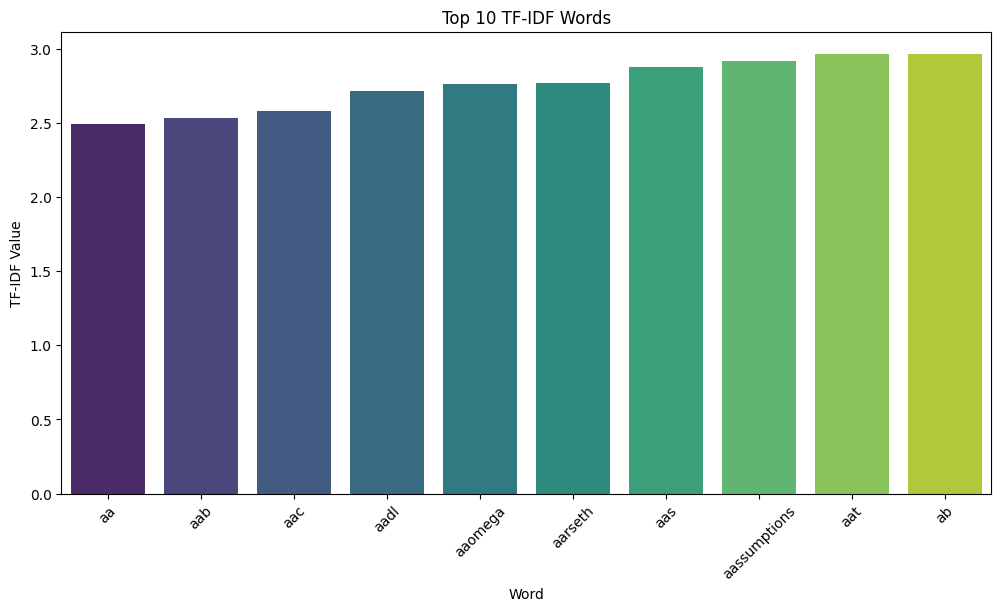

In [ ]:
top_words = np.array(tfidf.get_feature_names_out())[:10]
idf_values = np.sort(tfidf.idf_)[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words, y=idf_values, palette="viridis")
plt.xlabel("Word")
plt.ylabel("TF-IDF Value")
plt.title("Top 10 TF-IDF Words")
plt.xticks(rotation=45)
plt.show()